In [1]:
import torch
from PIL import Image
import h5py
from tqdm import tqdm
import json
import open_clip
import pickle
import matplotlib.pyplot as plt

# Load the configuration from the JSON file
config_path = "data_config.json"
with open(config_path, "r") as config_file:
    config = json.load(config_file)

device = "cuda:1" if torch.cuda.is_available() else "cpu"
# vlmodel, preprocess = clip.load("ViT-B/32", device=device)
model_type = 'ViT-H-14'
# We use create_model_and_transforms instead of create_model_from_pretrained to use the training preprocess pipeline,
# which incorporates augmentations
# https://huggingface.co/docs/hub/en/open_clip
vlmodel, preprocess_train, preprocess_val = open_clip.create_model_and_transforms(
    model_type, pretrained='laion2b_s32b_b79k', precision='fp32', device = device)
tokenizer = open_clip.get_tokenizer(model_type)


In [13]:
batch_size = 250  
image_features_list = []

with h5py.File(config["image_path"], 'r') as file:
    dataset = file["imgBrick"]
    # num_images = dataset.shape[0]
    num_images = 4000
    
    print("Encoding images")
    for i in tqdm(range(0, num_images, batch_size)):
        # Adjust slicing for batch processing
        batch_data = dataset[i:i + batch_size, :, :, :]
        # Preprocess images
        image_inputs = [preprocess_train(Image.fromarray(img)) for img in batch_data]
        image_inputs = torch.stack(image_inputs).to(device)

        with torch.no_grad():
            batch_image_features = vlmodel.encode_image(image_inputs)
            batch_image_features /= batch_image_features.norm(dim=-1, keepdim=True)
        
        image_features_list.append(batch_image_features)

image_features = torch.cat(image_features_list, dim=0)

Encoding images


100%|██████████| 16/16 [01:41<00:00,  6.35s/it]


In [3]:

text = None
with open(config["caption_path"], 'rb') as file:
    text = pickle.load(file)
firstText = [group[0] for group in text] # We just use the first out of 5 sentences  
text_tokens = tokenizer(firstText).to(device) # We just use the first out of 5 sentences   

batch_size = 1000
text_features_list = []

print("Encoding text")
for i in tqdm(range(0, len(text_tokens), batch_size)):
    tokens_batch = text_tokens[i:i+batch_size]
    with torch.no_grad():
        text_features_batch = vlmodel.encode_text(tokens_batch)
        text_features_batch /= text_features_batch.norm(dim=-1, keepdim=True)
    
    text_features_list.append(text_features_batch)
    
text_features = torch.cat(text_features_list, dim=0)

Encoding text


100%|██████████| 4/4 [00:13<00:00,  3.28s/it]


In [28]:
# sanity check text and image features are the same

# Assuming text_features and image_features are your tensors of shape [4000, 1024]
cosine_sim = torch.nn.functional.cosine_similarity(text_features, image_features, dim=1)
average_similarity = cosine_sim.mean()
print("Average Cosine Similarity:", average_similarity.item())


Average Cosine Similarity: 0.30784979462623596


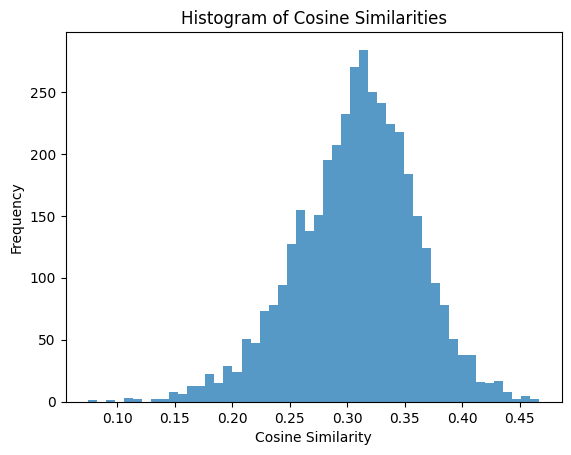

In [30]:
plt.hist(cosine_sim.cpu().numpy(), bins=50, alpha=0.75)
plt.title('Histogram of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


In [16]:
image_feature.shape

torch.Size([1, 1024])

A long train sitting on a railroad track. 


tensor([[ 0.0142, -0.0252,  0.0283,  ...,  0.0175, -0.0310, -0.0031],
        [ 0.0016,  0.0460, -0.0230,  ...,  0.0055, -0.0280,  0.0062],
        [-0.0059, -0.0089,  0.0192,  ...,  0.0337, -0.0295,  0.0008]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.0075, -0.0139,  0.0183,  ...,  0.0176, -0.0482,  0.0131]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.2771, 0.1326, 0.3943], device='cuda:0', grad_fn=<SumBackward1>)
tensor([[8.1010e-06, 4.3122e-12, 9.9999e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


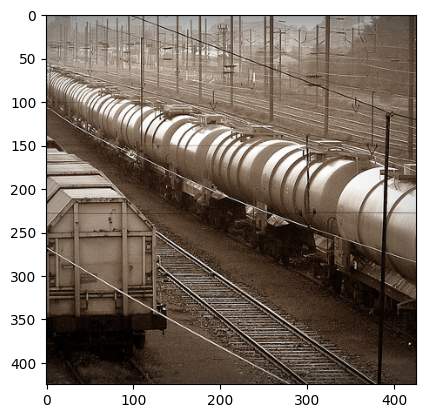

In [26]:
index = 11

with h5py.File(config["image_path"], 'r') as file:
    image = file["imgBrick"][index]
    text = firstText[index]
    print(text)
    plt.imshow(image)

    texts = [text, "a highway with a truck", "a train yard, sepia photo, oil tankers, cable lines"]
    textToken = tokenizer(texts).to(device)
    text_feature = vlmodel.encode_text(textToken)
    text_feature /= text_feature.norm(dim=-1, keepdim=True)
    print(text_feature)

    image_input = preprocess_train(Image.fromarray(image)).to(device).unsqueeze(0)
    image_feature = vlmodel.encode_image(image_input)
    image_feature /= image_feature.norm(dim=-1, keepdim=True)
    print(image_feature)

    cosine_sim = torch.nn.functional.cosine_similarity(text_feature, image_feature, dim=1)
    print(cosine_sim)

    text_probs = (100.0 * image_feature @ text_feature.T).softmax(dim=-1)
    print(text_probs)

In [2]:
from eegdatasets_leaveone import EEGDataset

sub = 'sub-01'
# Verify dataloader
train_dataset = EEGDataset(subjects=[sub], exclude_subject=None, split="train")

Encoding text


100%|██████████| 146/146 [03:41<00:00,  1.52s/it]


Encoding images


100%|██████████| 365/365 [51:16<00:00,  8.43s/it] 


In [11]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0, drop_last=True)


In [12]:
example = next(iter(train_loader))

In [13]:
example[0].shape

torch.Size([1, 64, 334])

Man on a skateboard wearing helmet and knee pads safety gear.


TypeError: Invalid shape () for image data

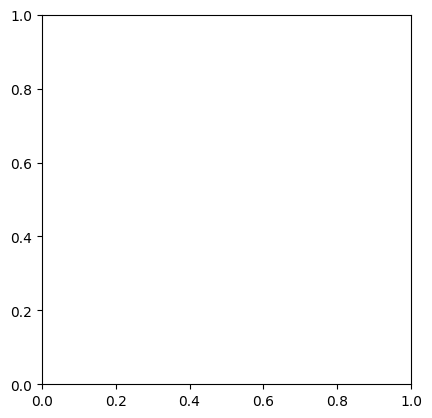

In [15]:
x, text, text_features, img, img_features = next(iter(train_loader))

print(text[0])
plt.imshow(img[0].cpu())

cosine_sim = torch.nn.functional.cosine_similarity(text_features, img_features, dim=1)
print(cosine_sim)

In [22]:
from datasets import load_dataset
import os

subjects = ['sub-01']
subject_ids = [int(sub.split('-')[1]) for sub in subjects]

dataset = load_dataset("Alljoined/05_125", split="train", cache_dir="/srv/eeg_reconstruction/shared")
dataset = dataset.filter(lambda example: example['subject_id'] in subject_ids)

texts = None
with open(config["caption_path"], 'rb') as file:
    texts = pickle.load(file)

model_type = 'ViT-H-14'
features_filename = f'{model_type}_Alljoined1_embedding.pt'
features_path = os.path.join("/srv/eeg_reconstruction/shared/biosemi-dataset", features_filename)

if os.path.exists(features_path):
    saved_features = torch.load(features_path)
    text_features = saved_features['text_features']
    img_features = saved_features['img_features']

Filter:   0%|          | 0/34354 [00:00<?, ? examples/s]

In [26]:
print(texts[7007])

['A zebra standing in tall brown grass in front of trees.', 'A zebra stands in a field of dried shrubs.', 'A single zebra standing in a tan veldt.', 'A zebra standing in  a dry field of grass.', 'A lone zebra stands in the dry savannah.']


In [29]:
index = 5

example = dataset[index]
x = torch.tensor(example['EEG']).float().detach()
id_73k = example['73k_id']
text = texts[id_73k][0] # Select the first of the 5 images
text_features = text_features[id_73k]
img = id_73k # We save img as id, to be indexed from hdf5 later
img_features = img_features[id_73k]

In [30]:
print(text)
print(example['coco_id'])

A persons hand with a doughnut held out.
531828
